<a href="https://colab.research.google.com/github/YanivRefaelovich/ML-Projects/blob/master/Help_Navigate_Robots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os

os.chdir('drive/My Drive/ML projects/Help Navigate Robots')
os.listdir()

['Data',
 'Submissions',
 'Copy of Help Navigate Robots.ipynb',
 'Help Navigate Robots.ipynb']

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns;sns.set(style="whitegrid")
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import warnings;warnings.filterwarnings("ignore")
from numpy.fft import fft

In [0]:
# plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred);
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title, ylabel='True label', xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [0]:
# reading data

X_train = pd.read_csv('Data/X_train.csv')
y_train = pd.read_csv('Data/y_train.csv')
X_test = pd.read_csv('Data/X_test.csv')
sample_submission = pd.read_csv('Data/sample_submission.csv')



---


**Data Description**

series_id - id of one second of data

measurement_number - 0-127 samples per seconds (128Hz)

group_id - group of several seconds (series_id) belong to group_id. each group belong to one surface


---




In [6]:
sample_submission.head()

,series_id,surface
0,0,concrete
1,1,concrete
2,2,concrete
3,3,concrete
4,4,concrete


In [7]:
print(X_train.shape, y_train.shape)

(487680, 13) (3810, 3)


In [8]:
X_train.isnull().sum()
print('number of columns witn Nan: ', X_train.isnull().sum().sum())

number of columns witn Nan:  0


In [9]:
X_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [0]:
X_train.drop(['row_id'], axis=1, inplace=True)

In [11]:
X_test.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.025773,-0.98864,-0.14801,0.003350,-0.006524,-0.001071,-0.027390,0.10043,4.2061,-5.5439
1,0_1,0,1,-0.025683,-0.98862,-0.14816,0.003439,-0.113960,0.083987,-0.060590,-0.70889,3.9905,-8.0273
2,0_2,0,2,-0.025617,-0.98861,-0.14826,0.003571,-0.080518,0.114860,-0.037177,1.45710,2.2828,-11.2990
3,0_3,0,3,-0.025566,-0.98862,-0.14817,0.003609,0.070067,0.033820,-0.035904,0.71096,1.8582,-12.2270
4,0_4,0,4,-0.025548,-0.98866,-0.14792,0.003477,0.152050,-0.029016,-0.015314,3.39960,2.7881,-10.4100


In [0]:
X_test.drop(['row_id'], axis=1, inplace=True)

In [13]:
X_train.describe()

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
count,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000,487680.000000
mean,1904.500000,63.500000,-0.018050,0.075062,0.012458,-0.003804,0.000178,0.008338,-0.019184,0.129281,2.886468,-9.364886
std,1099.853353,36.949327,0.685696,0.708226,0.105972,0.104299,0.117764,0.088677,0.229153,1.870600,2.140067,2.845341
min,0.000000,0.000000,-0.989100,-0.989650,-0.162830,-0.156620,-2.371000,-0.927860,-1.268800,-36.067000,-121.490000,-75.386000
25%,952.000000,31.750000,-0.705120,-0.688980,-0.089466,-0.106060,-0.040752,-0.033191,-0.090743,-0.530833,1.957900,-10.193000
50%,1904.500000,63.500000,-0.105960,0.237855,0.031949,-0.018704,0.000084,0.005412,-0.005335,0.124980,2.879600,-9.365300
75%,2857.000000,95.250000,0.651803,0.809550,0.122870,0.097215,0.040527,0.048068,0.064604,0.792263,3.798800,-8.522700
max,3809.000000,127.000000,0.989100,0.988980,0.155710,0.154770,2.282200,1.079100,1.387300,36.797000,73.008000,65.839000


In [14]:
X_train.dtypes

series_id                  int64
measurement_number         int64
orientation_X            float64
orientation_Y            float64
orientation_Z            float64
orientation_W            float64
angular_velocity_X       float64
angular_velocity_Y       float64
angular_velocity_Z       float64
linear_acceleration_X    float64
linear_acceleration_Y    float64
linear_acceleration_Z    float64
dtype: object

In [15]:
X_train['measurement_number'].unique().shape

(128,)

In [16]:
y_train.head()


,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete
3,3,31,concrete
4,4,22,soft_tiles


In [17]:
print('number of unique groups:  ', y_train['group_id'].unique().shape)

number of unique groups:   (73,)


In [18]:
print('there are ', y_train['surface'].unique().shape[0], ' unique surfaces.\n', y_train['surface'].unique())

there are  9  unique surfaces.
 ['fine_concrete' 'concrete' 'soft_tiles' 'tiled' 'soft_pvc'
 'hard_tiles_large_space' 'carpet' 'hard_tiles' 'wood']


In [19]:
# label encoding of surfaces
le = LabelEncoder()
y_train['labels'] =  le.fit_transform(y_train['surface'])
y_train.head(10)


,series_id,group_id,surface,labels
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,3,31,concrete,1
4,4,22,soft_tiles,6
5,5,1,tiled,7
6,6,34,soft_pvc,5
7,7,31,concrete,1
8,8,33,hard_tiles_large_space,4
9,9,11,tiled,7


In [20]:
group = y_train.groupby('group_id').agg({'surface':'nunique'})
print((group!=1).sum()[0], 'group_id with more than 1 surface.\n every group is for 1 surface only')


0 group_id with more than 1 surface.
 every group is for 1 surface only


In [0]:
# add y_train data to X_train
X_train = X_train.merge(y_train, how='left', on='series_id')

In [0]:
def quaternion_to_euler(x, y, z, w):
    
    import math
    
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll = math.atan2(t0, t1)
    
    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    pitch = math.asin(t2)
    
    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw = math.atan2(t3, t4)
    
    return [yaw, pitch, roll]


def quaternion_to_euler_vec(x, y, z, w):

  t0 = +2.0 * (np.multiply(w, x) + np.multiply(y, z))
  t1 = +1.0 - 2.0 * (np.multiply(x,x) + np.multiply(y, y))              
  roll = np.arctan2(t0, t1)

  t2 = +2.0 * (np.multiply(w, y) - np.multiply(z, x))
  t2[t2>1]=1  
  t2[t2<-1]=-1

  pitch = np.arcsin(t2)

  t3 = +2.0 * (np.multiply(w,z) + np.multiply(x, y))
  t4 = +1.0 - 2.0 * (np.multiply(y, y) + np.multiply(z, z))
  yaw = np.arctan2(t3, t4)

  return [yaw, pitch, roll]


def euler_to_direction(roll, pitch, yaw):
# If we define pitch=0 as horizontal (z=0) and yaw as counter-clockwise from the x axis, then the direction vector will be

  x = np.cos(yaw)*np.cos(pitch)
  y = np.sin(yaw)*np.cos(pitch)
  z = np.sin(pitch)
  
  return [x,y,z]

In [0]:
yaw_vec, pitch_vec, roll_vec = quaternion_to_euler_vec(X_train['orientation_X'].values, X_train['orientation_Y'].values, X_train['orientation_Z'].values, X_train['orientation_W'].values)
x_vec, y_vec, z_vec = euler_to_direction(roll_vec, pitch_vec, yaw_vec)

# X_train['yaw'] = yaw_vec
# X_train['pitch'] = pitch_vec
# X_train['roll'] = roll_vec
X_train['x_dir'] = x_vec
X_train['y_dir'] = y_vec
X_train['z_dir'] = z_vec

yaw_vec, pitch_vec, roll_vec = quaternion_to_euler_vec(X_test['orientation_X'].values, X_test['orientation_Y'].values, X_test['orientation_Z'].values, X_test['orientation_W'].values)
x_vec, y_vec, z_vec = euler_to_direction(roll_vec, pitch_vec, yaw_vec)

# X_test['yaw'] = yaw_vec
# X_test['pitch'] = pitch_vec
# X_test['roll'] = roll_vec
X_test['x_dir'] = x_vec
X_test['y_dir'] = y_vec
X_test['z_dir'] = z_vec

In [0]:
X_train.drop(['orientation_X','orientation_Y','orientation_Z','orientation_W'], axis=1, inplace=True)
X_test.drop(['orientation_X','orientation_Y','orientation_Z','orientation_W'], axis=1, inplace=True)

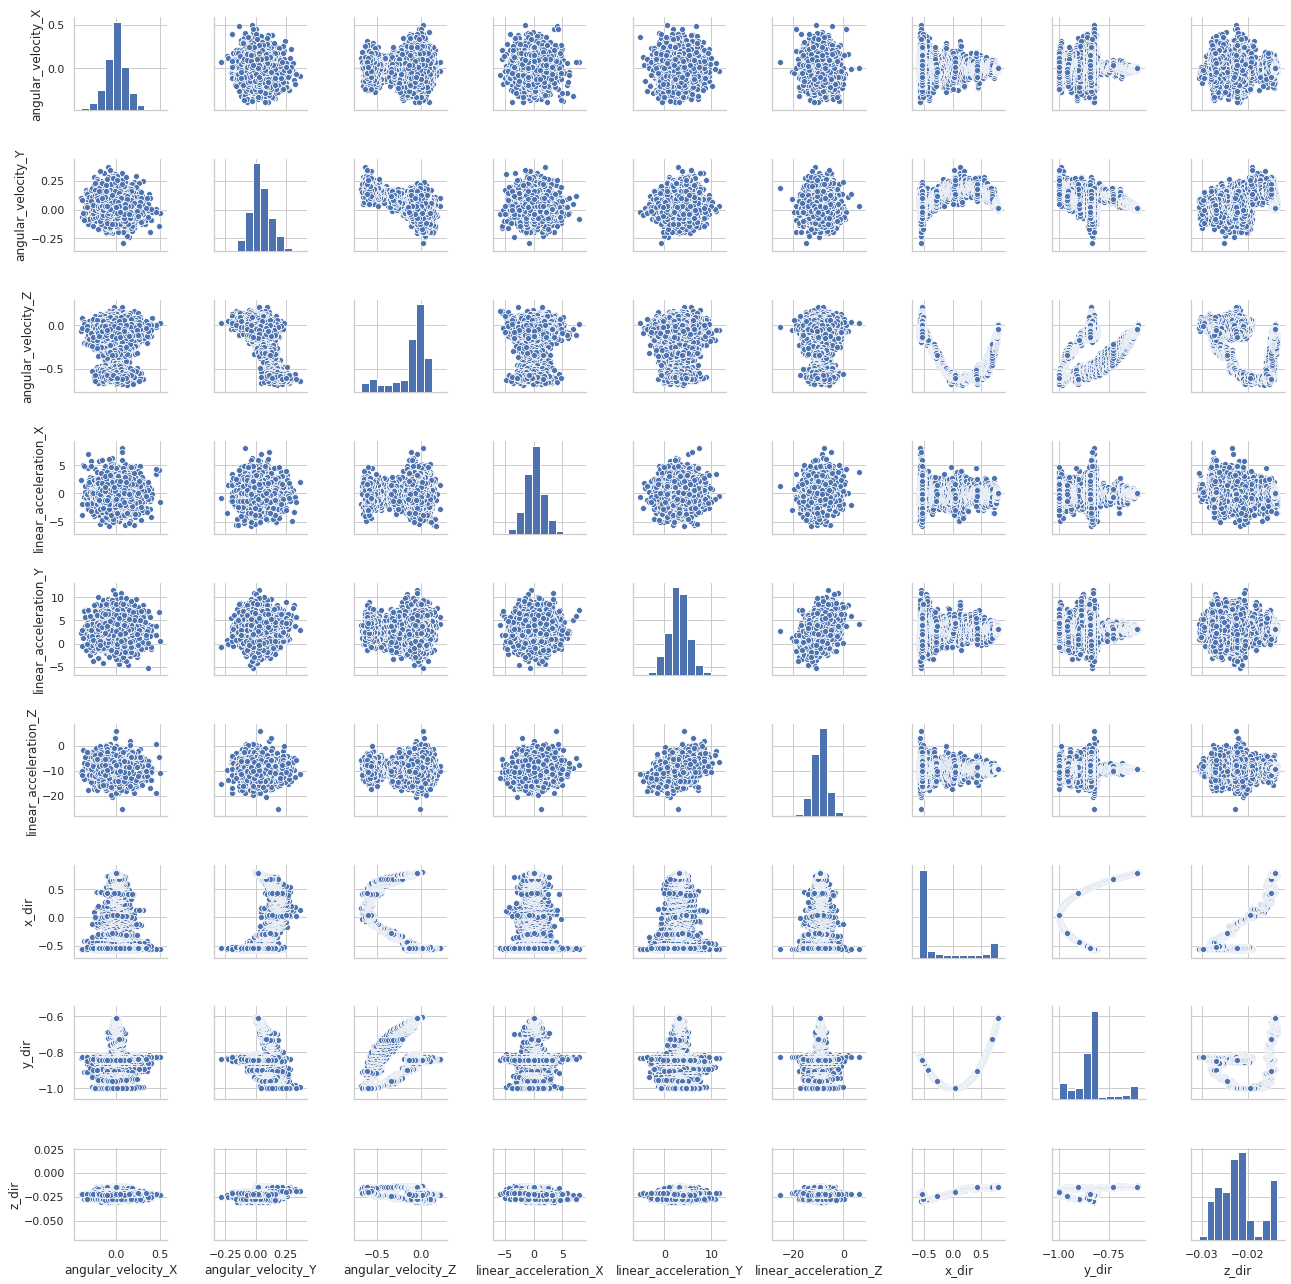

In [25]:
group_id = 1
data = X_train.loc[X_train['group_id']==group_id, :].drop([	'series_id',	'measurement_number','group_id','labels','surface'], axis=1)

sns.pairplot(data, height=2);

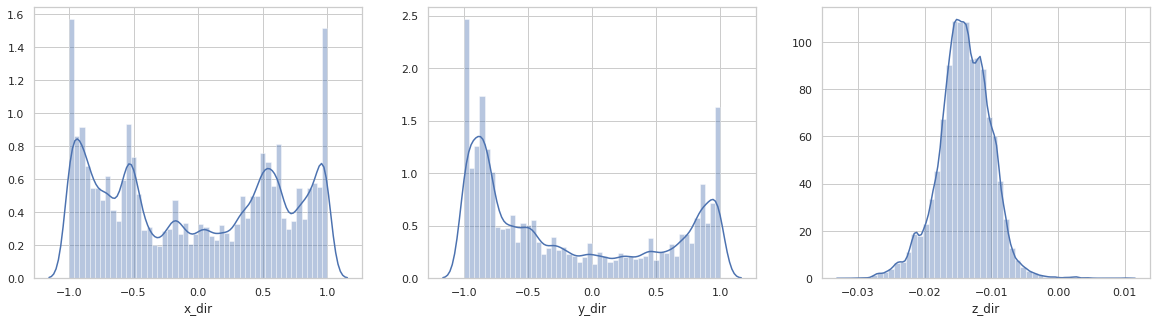

In [26]:
f, ax=plt.subplots(1,3, figsize=(20,5))
sns.distplot(X_train['x_dir'],ax=ax[0]);
sns.distplot(X_train['y_dir'],ax=ax[1]);
sns.distplot(X_train['z_dir'],ax=ax[2]);

                                                We can see that Z direction almost doesnt change.
                                                
                                                It seems like the robots walks on quite a flatt surface.
                                                
                                                But always pointing slightly downward





                                                  We can see here as well that Z and W are having smaller changes
                                                  
                                                  Most of the movements is across X and Y

All movement is over X-Y plane over Yaw axis

![alt text](https://www.machinedesign.com/sites/machinedesign.com/files/pry-promo.gif)



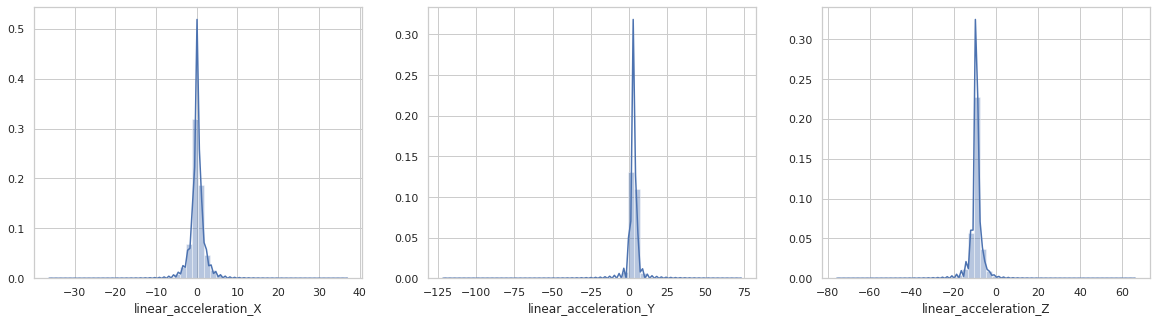

In [27]:
f, ax=plt.subplots(1,3, figsize=(20,5))
sns.distplot(X_train['linear_acceleration_X'],ax=ax[0]);
sns.distplot(X_train['linear_acceleration_Y'],ax=ax[1]);
sns.distplot(X_train['linear_acceleration_Z'],ax=ax[2]);


                                      It seems that the robot drive in constant speed in X and Y, and acclerates on Z

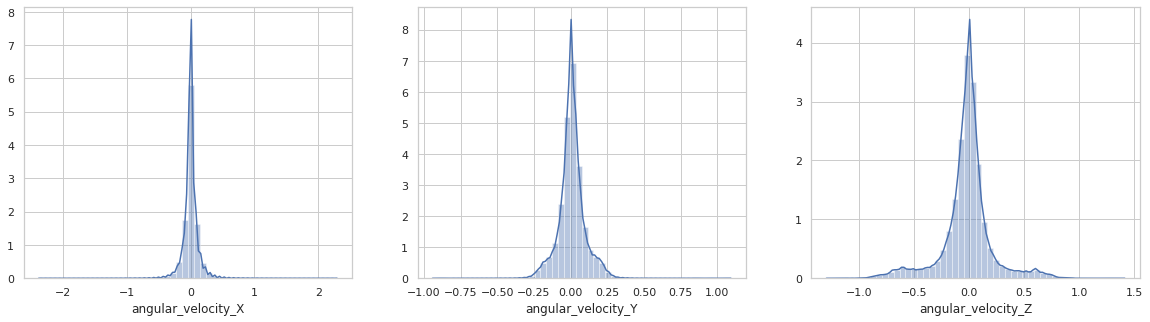

In [28]:
f, ax=plt.subplots(1,3, figsize=(20,5))
sns.distplot(X_train['angular_velocity_X'],ax=ax[0]);
sns.distplot(X_train['angular_velocity_Y'],ax=ax[1]);
sns.distplot(X_train['angular_velocity_Z'],ax=ax[2]);


In [0]:
X_train['angular_velocity_total'] = X_train['angular_velocity_X'].values**2 + X_train['angular_velocity_Y'].values**2 + X_train['angular_velocity_Z'].values**2
X_train['linear_acceleration_total'] = X_train['linear_acceleration_X'].values**2 + X_train['linear_acceleration_Y'].values**2 + X_train['linear_acceleration_Z'].values**2

X_test['angular_velocity_total'] = X_test['angular_velocity_X'].values**2 + X_test['angular_velocity_Y'].values**2 + X_test['angular_velocity_Z'].values**2
X_test['linear_acceleration_total'] = X_test['linear_acceleration_X'].values**2 + X_test['linear_acceleration_Y'].values**2 + X_test['linear_acceleration_Z'].values**2

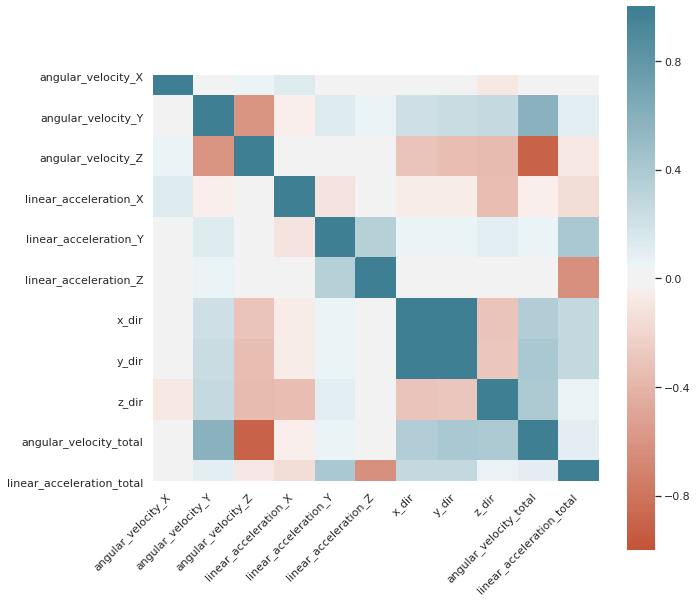

In [319]:
group_id = 5
data = X_train.loc[X_train['group_id']==group_id, :].drop(['series_id',	'measurement_number','group_id','labels','surface'], axis=1)

f,ax = plt.subplots(figsize=(10,10))

corr = data.corr()
sns.heatmap(corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
           axes=ax)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right');

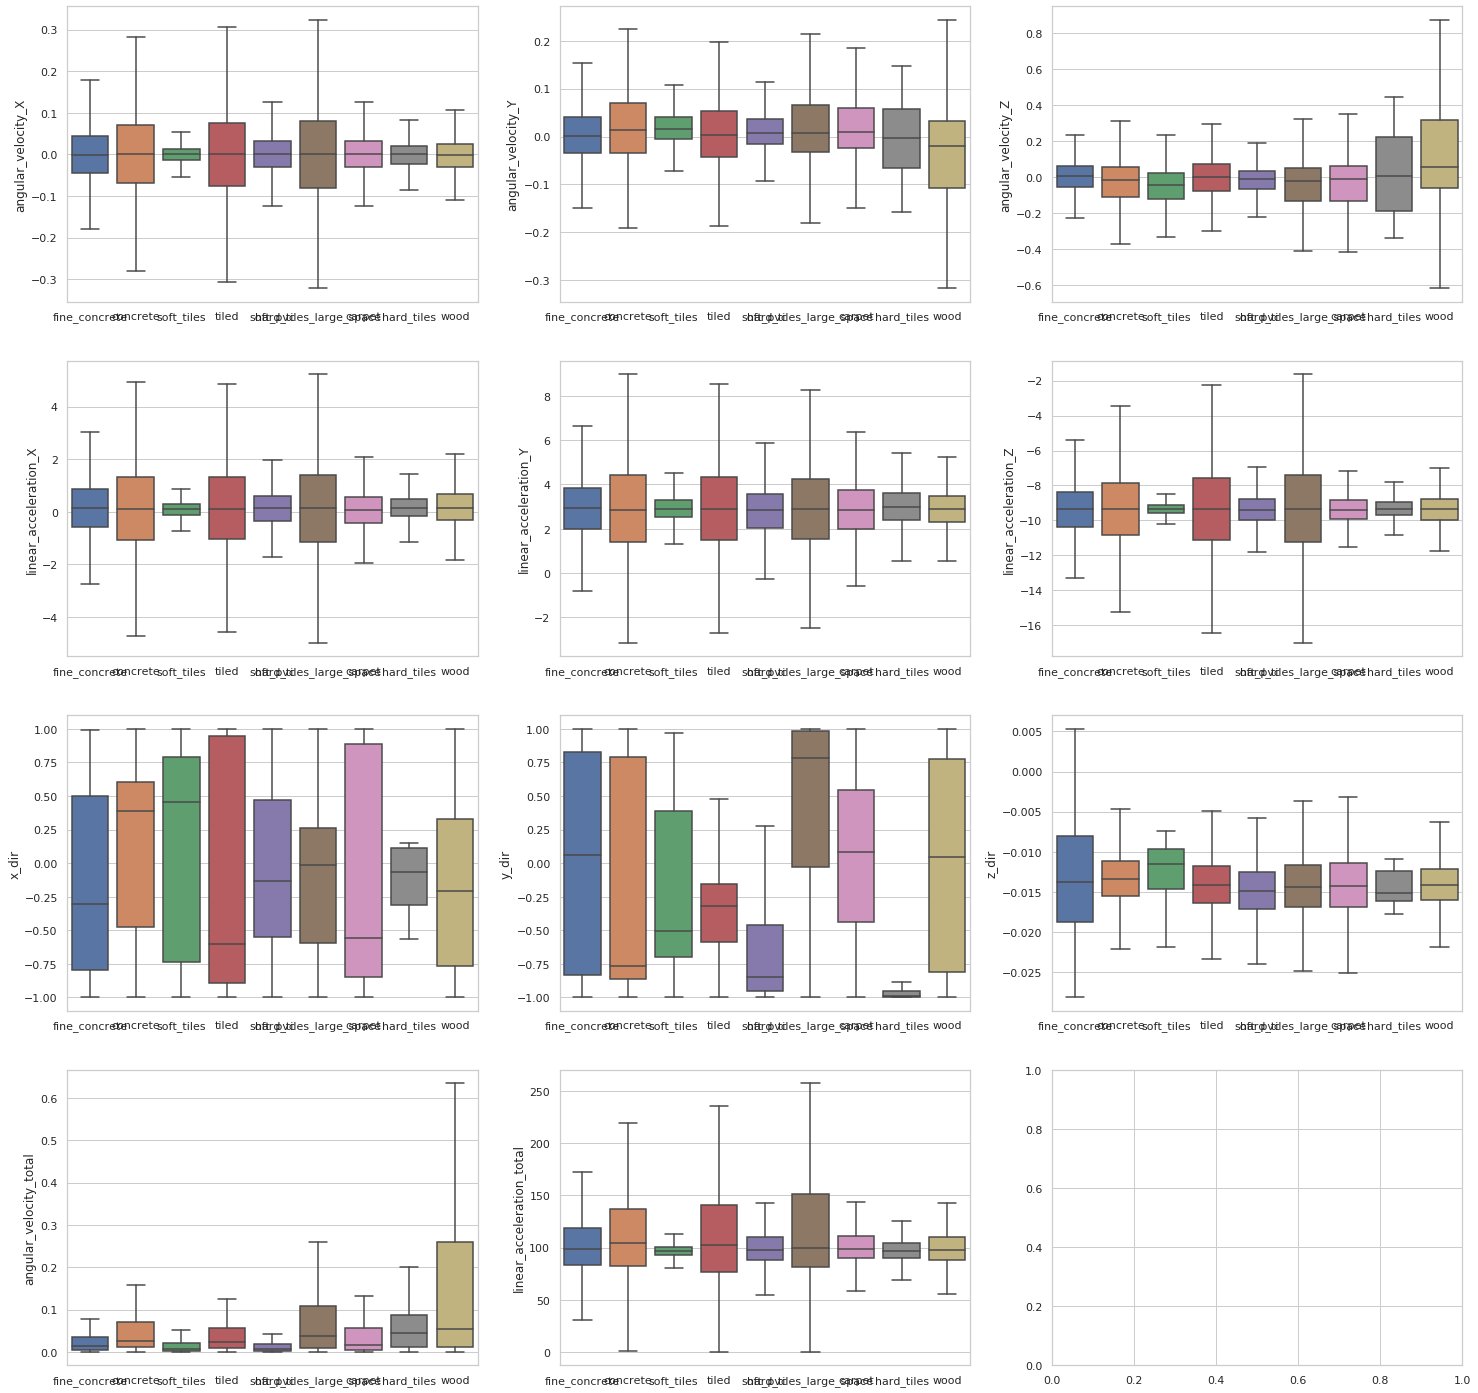

In [31]:
f, axes = plt.subplots(4,3, figsize=(25,25))
axes = axes.flatten()
columns_to_plot = [col for col in X_train.columns if col not in ['series_id', 'measurement_number', 'group_id', 'surface','labels']]

for i, col in enumerate(columns_to_plot):
  sns.boxplot(x='surface',y=col, data=X_train, showfliers=False, ax=axes[i])
  axes[i].set_xlabel('');

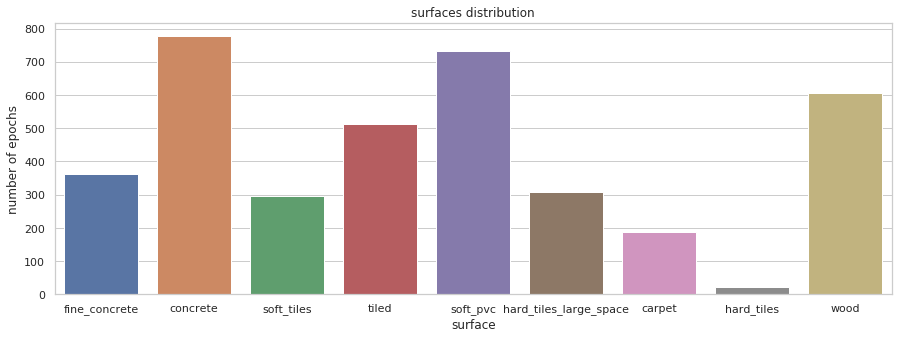

In [32]:
plt.figure(figsize=(15,5))
sns.countplot(x='surface',data=y_train);
plt.title('surfaces distribution');
plt.ylabel(('number of epochs'));

                                    We can see that the classes are not balanced

In [33]:
print('num epochs of hard_tiles: ', (y_train['surface']=='hard_tiles').sum())

num epochs of hard_tiles:  21


## orgenizing data in epochs of 128 samples

In [0]:
index = ['group_id','series_id','labels','surface']
values = [col for col in X_train.columns if col not in index]
pivot_train = X_train.pivot_table(values=values, index=index, columns='measurement_number').reset_index()

train_id = pivot_train[['group_id',	'series_id',	'labels',	'surface']]

index = ['series_id']
values = [col for col in X_test.columns if col not in index]
pivot_test = X_test.pivot_table(values=values, index=index, columns='measurement_number').reset_index()


In [35]:
X_train.head(10)

,series_id,measurement_number,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z,group_id,surface,labels,x_dir,y_dir,z_dir,angular_velocity_total,linear_acceleration_total
0,0,0,0.107650,0.017561,0.000767,-0.74857,2.103000,-9.7532,13,fine_concrete,2,0.173201,0.984578,-0.024665,0.011898,100.107876
1,0,1,0.067851,0.029939,0.003385,0.33995,1.506400,-9.4128,13,fine_concrete,2,0.173218,0.984575,-0.024660,0.005512,90.985611
2,0,2,0.007275,0.028934,-0.005978,-0.26429,1.592200,-8.7267,13,fine_concrete,2,0.173183,0.984579,-0.024726,0.000926,78.760243
3,0,3,-0.013053,0.019448,-0.008974,0.42684,1.099300,-10.0960,13,fine_concrete,2,0.173144,0.984585,-0.024767,0.000629,103.319869
4,0,4,0.005135,0.007652,0.005245,-0.50969,1.468900,-10.4410,13,fine_concrete,2,0.173172,0.984580,-0.024782,0.000112,111.431932
5,0,5,0.059664,0.013043,-0.013231,-0.44745,0.992810,-10.4020,13,fine_concrete,2,0.173120,0.984589,-0.024796,0.003905,109.387487
6,0,6,0.082140,0.044356,-0.002696,-0.14163,0.734970,-9.4296,13,fine_concrete,2,0.173078,0.984593,-0.024901,0.008722,89.477596
7,0,7,0.056218,0.038162,-0.022931,-0.12160,0.075417,-8.6088,13,fine_concrete,2,0.173005,0.984604,-0.024979,0.005143,74.131912
8,0,8,-0.012846,0.039004,-0.007831,1.60000,0.816110,-7.6426,13,fine_concrete,2,0.172958,0.984610,-0.025076,0.001748,61.635370
9,0,9,-0.090082,0.027299,-0.009970,0.47496,0.909600,-8.8120,13,fine_concrete,2,0.172992,0.984605,-0.025040,0.008959,78.704303


In [36]:
pivot_train.head(5)

group_id series_id labels  ...     z_dir                    
measurement_number                            ...       125       126       127
0                         0        70      1  ... -0.014277 -0.014124 -0.013934
1                         0        94      1  ... -0.015633 -0.015570 -0.015465
2                         0       139      1  ... -0.013217 -0.013327 -0.013749
3                         0       144      1  ... -0.016815 -0.017003 -0.017035
4                         0       151      1  ... -0.012580 -0.012505 -0.012596

[5 rows x 1412 columns]

In [37]:
pivot_test.head()

series_id angular_velocity_X  ...     z_dir          
measurement_number                            0  ...       126       127
0                          0          -0.006524  ... -0.014057 -0.014061
1                          1          -0.054829  ... -0.012563 -0.012712
2                          2          -0.214770  ... -0.015246 -0.015273
3                          3           0.001441  ... -0.012571 -0.012596
4                          4           0.025669  ... -0.012408 -0.012405

[5 rows x 1409 columns]

In [38]:
print(pivot_train.shape, train_id.shape)
print(pivot_test.shape)

(3810, 1412) (3810, 4)
(3816, 1409)


In [39]:
pivot_train['surface'].unique()

array(['concrete', 'tiled', 'wood', 'soft_pvc', 'soft_tiles', 'carpet',
       'fine_concrete', 'hard_tiles_large_space', 'hard_tiles'],
      dtype=object)

In [40]:
np.arange(1,10)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

# stratified group k fold

In [0]:
# vector of groups id
groups = pivot_train['group_id'].values

# vector of classes labels
labels = pivot_train['surface'].values

random_state=24
k=3

group_counts=pd.DataFrame()
group_counts['labels'] = labels
group_counts['group_id'] = groups
group_counts['counts']=1

group_counts = group_counts.groupby(by=['labels','group_id'], as_index=False).count()

group_counts.head()
folds_per_class={}
folds_inds_all= {i: [] for i in range(k)}
folds_inds_all = [[] for i in range(k)]

for label in group_counts['labels'].unique():
  print(label)
  class_size=np.sum(labels==label)

  groups_length=group_counts.loc[group_counts['labels']==label, 'counts'].values
  groups_id = group_counts.loc[group_counts['labels']==label, 'group_id'].values

  if groups_length.shape[0]<k:
    print('error. number of groups in "', label,'" is less that ', k)
    print('number of samples: ', np.sum(groups_length))

  np.random.seed(random_state)
  shuffle_inds=np.random.permutation(groups_length.shape[0]) 

  shuffled_groups_length=groups_length[shuffle_inds]
  shuffled_groups_id = groups_id[shuffle_inds]

  cumsum = np.cumsum(shuffled_groups_length)/shuffled_groups_length.sum()

  inds_folds_1=[]
  inds_folds_2=[]
  inds_folds_3=[]

# ---------method 1 - find the closest to fold size---------
  prev=0
  for i in np.arange(1, k+1):
    
    current = np.argmin(np.abs(cumsum-i/k))+1
    groups = shuffled_groups_id[np.arange(prev,current)]
    inds_folds_1.append(np.where(np.isin(pivot_train['group_id'], groups))[0])
    prev= current

  # testing
  if class_size==np.sum([l.shape[0] for l in inds_folds_1]):
    print('Method1 is OK' )




# ---------method 2 - find right after---------
  prev=0
  for i in np.arange(1,k+1):
    
    current = np.where(cumsum>=i/k)[0][0]
    groups = shuffled_groups_id[np.arange(prev,current+1)]
    inds_folds_2.append(np.where(np.isin(pivot_train['group_id'], groups))[0])
    prev= current+1
  
  # testing
  if class_size==np.sum([l.shape[0] for l in inds_folds_2]):
    print('Method2 is OK' )




# ---------method 3 - find right before---------
  prev=0
  for i in np.arange(1, k+1):
    
    if i==k:
      current=shuffled_groups_id.shape[0]
    else:
      current = np.where(cumsum>=i/k)[0][0]

    groups = shuffled_groups_id[np.arange(prev,current)]
    inds_folds_3.append(np.where(np.isin(pivot_train['group_id'], groups))[0])
    prev= current
  
  # testing
  if class_size==np.sum([l.shape[0] for l in inds_folds_3]):
    print('Method3 is OK' )


  # calculating std over splits to find the best split
  std = [np.std([x.shape[0] for x in inds_folds_1]), np.std([x.shape[0] for x in inds_folds_2]), np.std([x.shape[0] for x in inds_folds_3])]


  # take group with the most similar splits
  if (std[0]<std[1]) & (std[0]<std[2]):

    best_split = inds_folds_1

  elif std[1]<std[2]:

    best_split = inds_folds_2

  else:
    best_split = inds_folds_3

  for i in range(k):
    folds_inds_all[i].extend(best_split[i])
  
  folds_per_class[label] = best_split

 # testing
  
if np.unique(np.concatenate(folds_inds_all).flatten()).shape[0]==labels.shape[0]:
  print('\nnumber of samples in folds is equal to total number of samples.')
else:
  print('\nError.number of samples in folds is NOT equal to total number of samples.')

# arranging in train test inds
train_test_inds=[]
for i in range(k):
  test = np.array(folds_inds_all[i])
  temp=folds_inds_all.copy()
  temp.pop(i)
  train=np.concatenate(temp)
  train_test_inds.append((train, test))

if len(train_test_inds)==k:
  print('number of folds is OK')

if np.sum([True if np.unique(np.concatenate([x[0],x[1]]).flatten()).shape[0]==labels.shape[0] else False for x in train_test_inds ])==k:
  print('train test split is OK')

if np.sum([True if np.intersect1d(x[0], x[1]).shape[0]==0 else False for x in train_test_inds ])==k:
  print('unique groups is OK')  

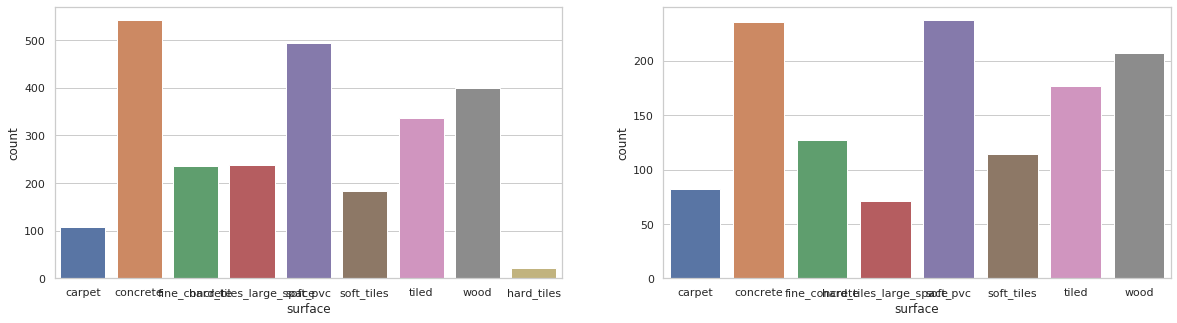

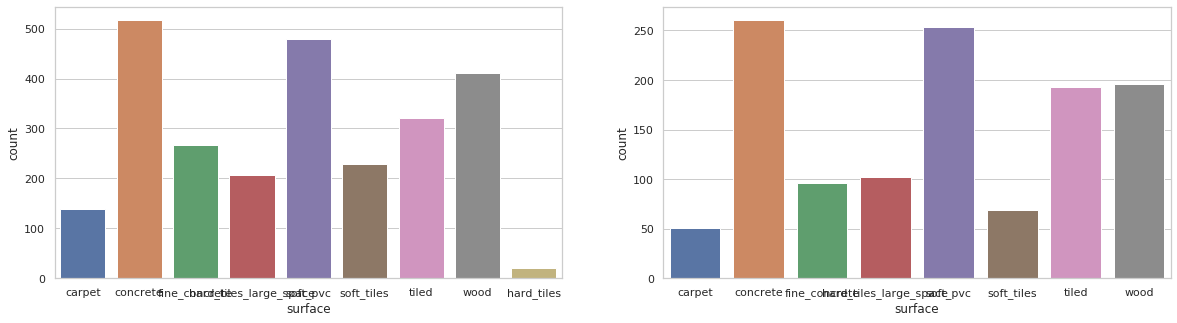

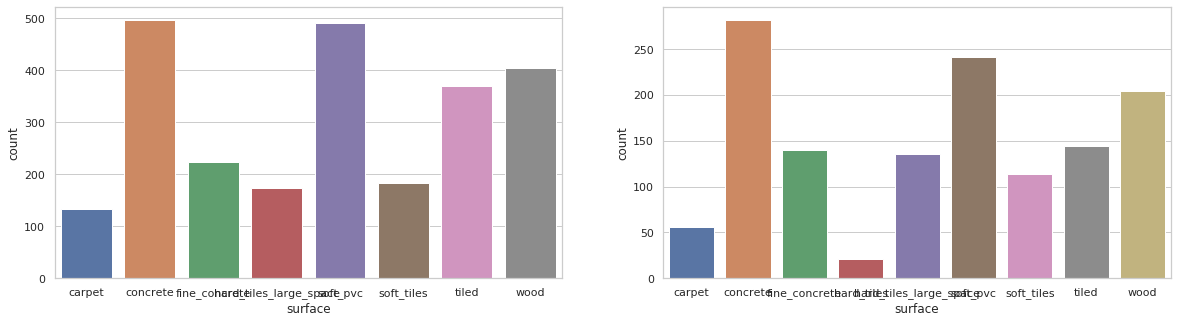

In [42]:
# test train test split

for (train_inds, test_inds) in train_test_inds:
  plt.figure(figsize=(20,5))
  plt.subplot(1,2,1)
  sns.countplot(x='surface',data=pivot_train.loc[train_inds,:])
  plt.subplot(1,2,2)
  sns.countplot(x='surface',data=pivot_train.loc[test_inds,:])

# Functions

In [0]:
def calculate_basic_features(df, name):
  
  features=pd.DataFrame()
  
  # basic characterization
  features[name+ '_mean'] = df.mean(axis=1)
  features[name+ '_std'] = df.std(axis=1)
  features[name+ '_max'] = df.max(axis=1)
  features[name+ '_min'] = df.min(axis=1)
  features[name+ '_pct25'] = df.quantile(q=0.25, axis=1)
  features[name+ '_pct75'] = df.quantile(q=0.75, axis=1)
  


  return features



def calc_power_spectrum_bins(df, col):

  df_fft = fft(df.sub(df.mean(axis=1), axis=0), axis=1)

  df_fft = np.abs(df_fft[:, 0:64])
  df_fft = pd.DataFrame(data=df_fft)
  columns=[(col, i) for i in range(df_fft.shape[1])]
  df_fft.columns=pd.MultiIndex.from_tuples(columns)

  
  return df_fft


def subsampling_freq(df, col, win):
  
  df = df.rolling(win, axis=1).mean()
  sub_inds = np.arange( win-1, df.shape[1], win)
  df = df.iloc[:, sub_inds]
  
  columns=[(col, i) for i in range(df.shape[1])]
  df.columns=pd.MultiIndex.from_tuples(columns)

  return df


### calculating basic features

In [0]:
colls_for_basic_features = [#'angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z',
                            #'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z',
                            #'x_dir','y_dir','z_dir',
                            'angular_velocity_total', 'linear_acceleration_total'
                           ]

X_train_basic_features=pd.DataFrame()
X_test_basic_features=pd.DataFrame()

for col in colls_for_basic_features:
  
  features = calculate_basic_features(df = pivot_train[col], name = col)
  X_train_basic_features = pd.concat([X_train_basic_features, features], axis=1)
    
  features = calculate_basic_features(df = pivot_test[col], name = col)
  X_test_basic_features = pd.concat([X_test_basic_features, features], axis=1)


In [405]:
print(X_train_basic_features.shape, X_test_basic_features.shape)

(3810, 12) (3816, 12)


In [406]:
# check for nans
print(X_train_basic_features.isnull().sum().sum())
print(X_test_basic_features.isnull().sum().sum())


0
0


### calculating FFT on each signal

In [0]:
colls_for_fft = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
                      'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z',
                      #'x_dir','y_dir','z_dir',
                      #'angular_velocity_total','linear_acceleration_total'
                ]


In [0]:
X_train_fft = pd.DataFrame()
X_test_fft = pd.DataFrame()

for col in colls_for_fft:

  df_fft = calc_power_spectrum_bins(pivot_train[col], col)
  X_train_fft = pd.concat([X_train_fft, df_fft], axis=1)

  df_fft = calc_power_spectrum_bins(pivot_test[col], col)
  X_test_fft = pd.concat([X_test_fft, df_fft], axis=1)

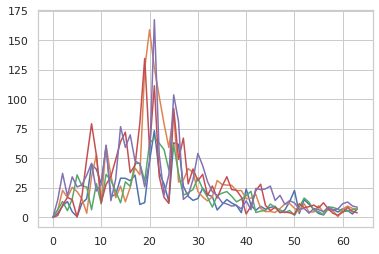

In [409]:
plt.plot(X_train_fft[col].iloc[0:5,:].values.T);


In [410]:
print(X_train_fft.shape, X_test_fft.shape)

(3810, 384) (3816, 384)


## subsampling the frequencies

In [0]:
X_train_fft_features = pd.DataFrame()
X_test_fft_features = pd.DataFrame()

win = 4

for col in colls_for_fft:

  df = subsampling_freq(X_train_fft[col], col, win)
  X_train_fft_features = pd.concat([X_train_fft_features, df], axis=1)

  df = subsampling_freq(X_test_fft[col], col, win)
  X_test_fft_features = pd.concat([X_test_fft_features, df], axis=1)

In [412]:
X_train_fft_features.head()
X_train_fft_features.shape

(3810, 96)

# prepare data for cnn


### normalizing each signal by the mean and variance of all signals


In [0]:
colls_for_cnn = ['angular_velocity_X', 'angular_velocity_Y', 'angular_velocity_Z', 
                      'linear_acceleration_X', 'linear_acceleration_Y', 'linear_acceleration_Z',
                      #'x_dir','y_dir','z_dir',
                      #'angular_velocity_total','linear_acceleration_total',
                ]


norm_X_train=pivot_train[colls_for_cnn]
norm_X_test=pivot_test[colls_for_cnn]

for col in [col for col in colls_for_cnn if 'dir' not in col]:

  current_data = pivot_train[col].values.flatten()
  mean = np.mean(current_data)
  std = np.std(current_data)
  norm_X_train[col] = (pivot_train[col]-0)/1
  norm_X_test[col] = (pivot_test[col]-0)/1

# for col in [col for col in colls_for_cnn if 'dir' in col]:

#   current_data = pivot_train[col]
#   mean = current_data.mean(axis=1)
#   std = current_data.std(axis=1)
  
  
  
#   X[col] = (pivot_train[col].sub(mean, axis=0)).divide(std,axis=0)


In [414]:
norm_X_test.shape

(3816, 768)

### reshaping signals into matrix on (N X number of channels)

In [0]:
norm_X_train = norm_X_train.values
norm_X_test = norm_X_test.values

num_vars = np.int(norm_X_train.shape[1]/128)
X_train_features_cnn = np.zeros((norm_X_train.shape[0], 128, num_vars))
X_test_features_cnn = np.zeros((norm_X_test.shape[0], 128, num_vars))

for i in range(X_train_features_cnn.shape[0]):
  X_train_features_cnn[i,:,:] = np.reshape(norm_X_train[i, :].T, (128, num_vars), order='F')

for i in range(X_test_features_cnn.shape[0]):
  X_test_features_cnn[i,:,:] = np.reshape(norm_X_test[i, :].T, (128, num_vars), order='F')



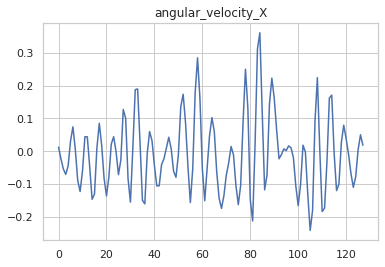

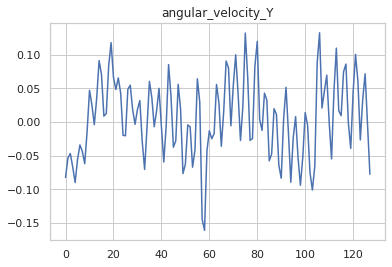

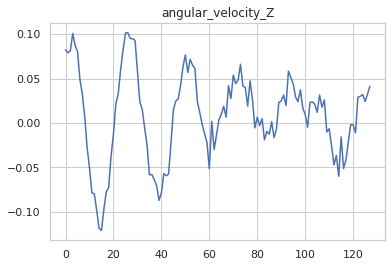

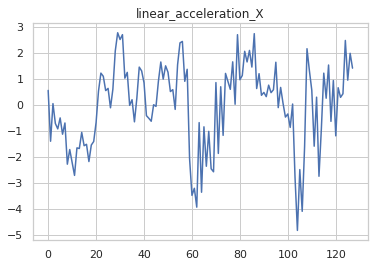

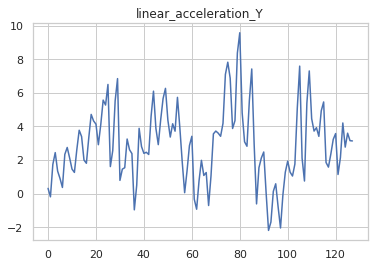

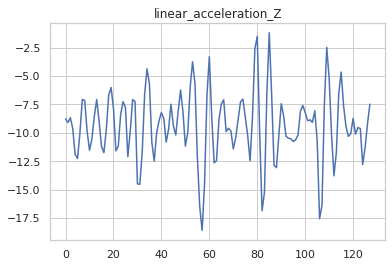

In [416]:
X_train_features_cnn.shape
for i in range(X_train_features_cnn.shape[2]):
  plt.figure()
  plt.plot(X_train_features_cnn[1000, :, i])
  plt.title(colls_for_cnn[i])

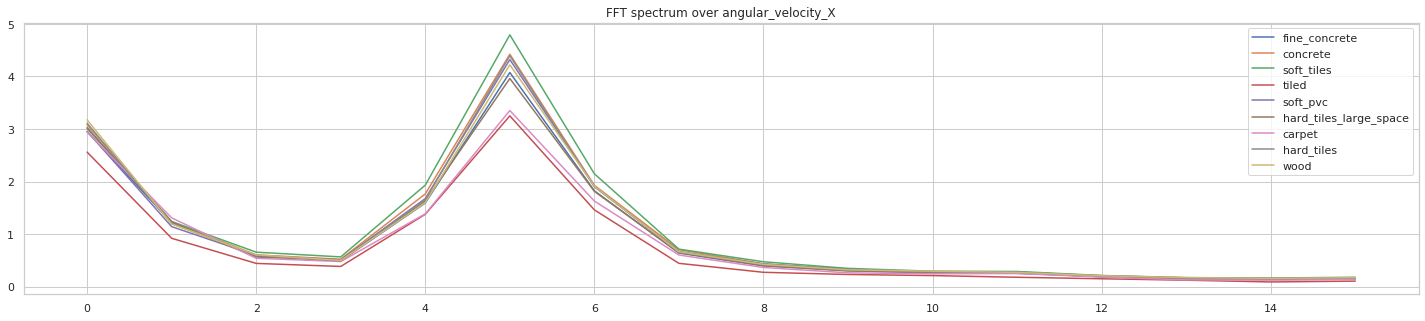

In [417]:
df = pd.concat([X_train_fft_features, y_train['surface']], axis=1, levels=[0])
cols = X_train_fft_features.columns

cols = list(df.columns)
cols = [(col,'') if type(col) is str else col for col in cols]

df.columns = pd.MultiIndex.from_tuples(cols)
df_averaged = df.groupby(by=['surface']).mean()
df_averaged.head()

col = df_averaged.columns[0][0]
plt.figure(figsize=(25,5))
plt.plot(df_averaged.loc[:,col].values.T);
plt.legend(y_train['surface'].unique());
plt.title('FFT spectrum over ' + col);


In [418]:
groups = y_train[['group_id','surface','labels']].drop_duplicates().reset_index()
groups.head()

,index,group_id,surface,labels
0,0,13,fine_concrete,2
1,1,31,concrete,1
2,2,20,concrete,1
3,4,22,soft_tiles,6
4,5,1,tiled,7


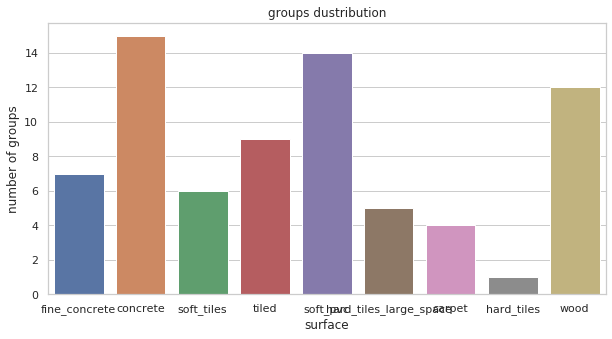

In [419]:
plt.figure(figsize=(10,5));
sns.countplot(x='surface',data=groups.reset_index());
plt.title('groups dustribution');
plt.ylabel('number of groups');

In [420]:
(groups['surface']=='hard_tiles').sum()

1

## model development

In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
 
X_dnn = pd.concat([X_train_basic_features, X_train_fft_features], axis=1)
# X_dnn = X_train_basic_features
X_dnn = scaler.fit_transform(X_dnn)

# X_dnn_test =  X_test_basic_features
X_dnn_test = pd.concat([X_test_basic_features, X_test_fft_features], axis=1)
X_dnn_test = scaler.transform(X_dnn_test)


# DNN

In [0]:
import keras
from keras.layers import Input, Dense, Dropout, Conv1D, MaxPool1D, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from keras import optimizers

In [424]:
X_dnn.shape

(3810, 108)

In [0]:
dnn_inputs = Input(shape=(X_dnn.shape[1],))
x = Dense(40, activation='relu')(dnn_inputs)
x = Dropout(rate=0.5)(x)
# x = Dense(35, activation='relu')(x)
# x = Dropout(rate=0.5)(x)
output_dnn = Dense(20, activation='relu')(x)

# output_dnn = Dense(9, activation='softmax')(x)

# model = Model(inputs = inputs, outputs = output)
# model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])



# 1D CNN

In [0]:
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state=0)
train_test_inds_=list(skf.split(pivot_train, pivot_train['labels']))

In [0]:
X_cnn = X_train_features_cnn

In [0]:
# x = Conv1D('num_filters','filter_size', activation='relu')(cnn_inputs)


cnn_inputs = Input(shape=(X_cnn.shape[1], X_cnn.shape[2],))
x = Conv1D(50,80, activation='relu')(cnn_inputs)
# x = Conv1D(10,50, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
output_cnn = Dense(20, activation='relu')(x)

# model = Model(inputs = inputs, outputs = output)
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
x = keras.layers.concatenate([output_dnn, output_cnn])

x = Dropout(0.5)(x)

x = Dense(20, activation='relu')(x)

final_output = Dense(9, activation='softmax')(x)

In [0]:
# model = Model(inputs=[cnn_inputs, dnn_inputs], outputs=[final_output])
model = Model(inputs=[cnn_inputs, dnn_inputs], outputs=[final_output])

In [442]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 108)          0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 128, 6)       0                                            
__________________________________________________________________________________________________
dense_61 (Dense)                (None, 40)           4360        input_23[0][0]                   
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 49, 50)       24050       input_25[0][0]                   
___________________________________________________________________________________________

In [443]:
le.classes_

array(['carpet', 'concrete', 'fine_concrete', 'hard_tiles',
       'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled',
       'wood'], dtype=object)

In [444]:
surface_weight = (pivot_train[['surface','labels']].groupby(by='surface').count()/pivot_train.shape[0]).values
inv_surface_weight = surface_weight #(1/surface_weight)/np.sum(1/surface_weight)
inv_surface_weight

array([[0.0496063 ],
       [0.20446194],
       [0.09527559],
       [0.00551181],
       [0.0808399 ],
       [0.19212598],
       [0.07795276],
       [0.13490814],
       [0.15931759]])

In [0]:
y = pd.get_dummies(pivot_train['labels'])
class_weight = {0:0.7,
                1:1,
                2:1,
                3:1,
                4:1,
                5:0.5,
                6:1,
                7:1,
                8:1,}

# class_weight={i:inv_surface_weight[i][0] for i in range(inv_surface_weight.shape[0])}



In [0]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
init_weights = model.get_weights()

In [0]:
from keras.callbacks import EarlyStopping
el = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, restore_best_weights=True)

In [469]:
oof_true=np.array([])
oof_pred=np.array([])
oof_test=[]


for i, inds in enumerate(train_test_inds_):
  
#   train_inds = inds[0]
#   val_inds = inds[1]
  
  train_inds = train_test_inds_[i][0]
  val_inds = train_test_inds_[i][1]

  model.set_weights(init_weights)
  history = model.fit([X_cnn[train_inds,:,:], X_dnn[train_inds,:]], y.iloc[train_inds,:],
                      batch_size=32,
                      epochs=100, 
                      validation_data=([X_cnn[val_inds,:,:], X_dnn[val_inds,:]], y.iloc[val_inds,:]),
                      shuffle=True,
                      class_weight=class_weight,
                      callbacks=[el],
                      verbose=0)
  
  y_pred = model.predict([X_cnn[val_inds,:,:], X_dnn[val_inds,:]])
  y_pred_test = model.predict([X_test_features_cnn, X_dnn_test])
  
  oof_test.append(np.argmax(y_pred_test, axis=1)) 
  oof_pred = np.append(oof_pred, np.argmax(y_pred, axis=1), axis=0)
  oof_true = np.append(oof_true, np.argmax(y.iloc[val_inds,:].values, axis=1), axis=0)

# classes = le.classes_
  
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels




Restoring model weights from the end of the best epoch
Epoch 00089: early stopping
Restoring model weights from the end of the best epoch
Epoch 00065: early stopping
Restoring model weights from the end of the best epoch
Epoch 00064: early stopping


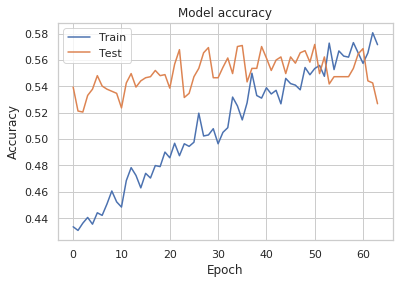

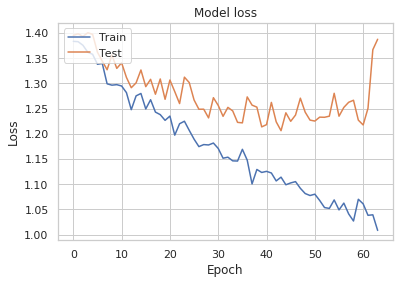

Confusion matrix, without normalization
                        precision    recall  f1-score   support

                carpet       0.00      0.00      0.00       189
              concrete       0.55      0.69      0.61       779
         fine_concrete       0.40      0.16      0.23       363
            hard_tiles       0.00      0.00      0.00        21
hard_tiles_large_space       0.71      0.32      0.44       308
              soft_pvc       0.69      0.68      0.69       732
            soft_tiles       0.48      0.96      0.64       297
                 tiled       0.49      0.59      0.53       514
                  wood       0.63      0.65      0.64       607

              accuracy                           0.57      3810
             macro avg       0.44      0.45      0.42      3810
          weighted avg       0.55      0.57      0.54      3810



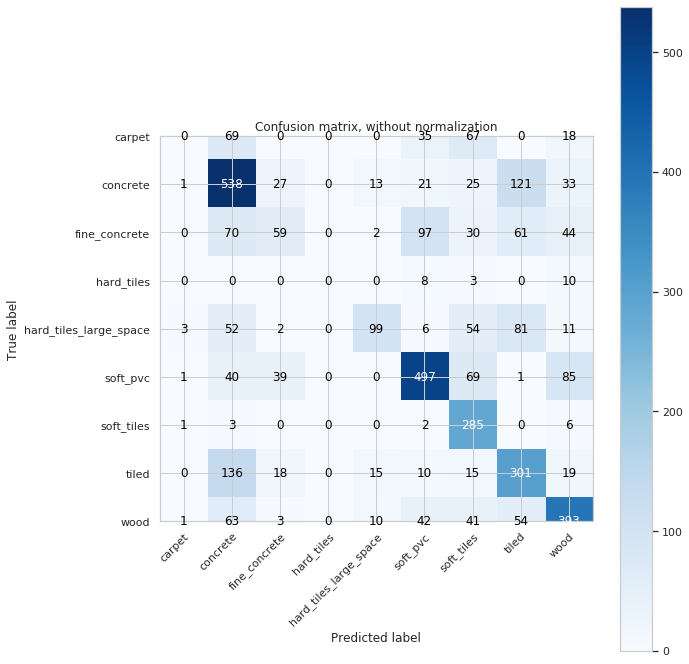

In [470]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

classes = le.classes_

plot_confusion_matrix(oof_true.astype(int), oof_pred.astype(int), classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues);

from sklearn.metrics import classification_report
print(classification_report(oof_true, oof_pred, target_names=classes,  digits=2, output_dict=False))

In [0]:
from scipy import stats
results = stats.mode(np.vstack(oof_test), axis=0).mode[0]
results.shape

y_test_surface = le.inverse_transform(results)
sample_submission['surface'] = y_test_surface
sample_submission.to_csv('Submissions/CareerCon_submission_8_cnn_fft.csv', index=False)